Dataset is from a bar in Downtown. The data contains information on sales in high-end bar-cum-restaurant.

Objective: To use the data that is shared, and make it ready to provide the infomation that is required on the dashboard shown below.

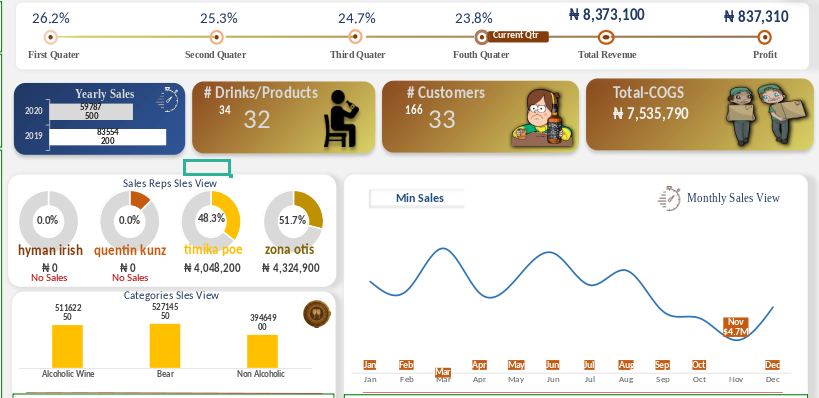

In [1]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import warnings
warnings.filterwarnings("ignore")
import openpyxl

In [4]:
mainSheet = pd.read_excel("Ann Driks Dashboard.xlsx",
                          sheet_name="Database",header=0)

In [5]:
mainSheet.head(2)

,Id,Date,Customers,Gender,Sales Reps,Drinks/Products,Categories,Cost,Sals Price,Qty,Cogs,Revenue,Profit
0,1,2019-01-01,Bernard Weatherly,M,timika poe,Heineken Bottle,Alcoholic Wine,38250,42500,3,114750,127500,12750
1,2,2019-01-02,Cordia Knopp,F,zona otis,Origin Bottle,Alcoholic Wine,2700,3000,5,13500,15000,1500


In [27]:
#Ensure there are no special character in the column names. 
#They will create challenge when querying
mainSheet.columns = ['Id', 'Date', 'Customers', 'Gender', 'SalesReps', 'Drinks_Products',
       'Categories', 'Cost', 'SalsPrice', 'Qty', 'Cogs', 'Revenue', 'Profit']

The dataframe has to be moved to a database for easier querying, and faster analysis. In this notebook the Pyspark spark session will be used to convert the dataframe into Spark dataframe, and then push it to database.

In [2]:
spark = SparkSession.builder.appName("dashDB") \
        .config("spark.jars","/usr/share/java/postgresql-42.2.26.jar") \
        .getOrCreate()

22/12/01 08:28:02 WARN Utils: Your hostname, codeStation resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
22/12/01 08:28:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/01 08:28:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
sparkread = spark.read
sparkcon = spark.sparkContext

In [28]:
#creating DF from pandas
annSparkDF = spark.createDataFrame(mainSheet)
annSparkDF.count()

683

In [29]:
#To make querying easier, creating a view table in spark context
spark.sql("CREATE DATABASE IF NOT EXISTS dashboard_wh")
spark.sql("USE dashboard_wh")
annSparkDF.createOrReplaceTempView("ann_saletable")

When the table is created using the createOrReplaceTempView, the data is inside the spark context.In order for the data to be saved to local folder the saveAsTable() method has to be invoked. 

The data manipulation activity will be done on the temporary table only.

The database is created inside a common folder, where the Jupyter-notebook session has been inititated. (Need to learn the cell magic to find this information)

In [30]:
spark.sql("SELECT * FROM ann_saletable").write \
    .saveAsTable("sale_table",mode='overwrite')
spark.sql("show tables").show()

+------------+-------------+-----------+
|   namespace|    tableName|isTemporary|
+------------+-------------+-----------+
|dashboard_wh|   sale_table|      false|
|            |ann_saletable|       true|
|            | product_sale|       true|
+------------+-------------+-----------+



In [31]:
annSparkDF.printSchema()

root
 |-- Id: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Customers: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- SalesReps: string (nullable = true)
 |-- Drinks_Products: string (nullable = true)
 |-- Categories: string (nullable = true)
 |-- Cost: long (nullable = true)
 |-- SalsPrice: long (nullable = true)
 |-- Qty: long (nullable = true)
 |-- Cogs: long (nullable = true)
 |-- Revenue: long (nullable = true)
 |-- Profit: long (nullable = true)



In [32]:
spark.sql("SELECT * FROM ann_saletable").show(2)

+---+-------------------+-----------------+------+----------+---------------+---------------+-----+---------+---+------+-------+------+
| Id|               Date|        Customers|Gender| SalesReps|Drinks_Products|     Categories| Cost|SalsPrice|Qty|  Cogs|Revenue|Profit|
+---+-------------------+-----------------+------+----------+---------------+---------------+-----+---------+---+------+-------+------+
|  1|2019-01-01 00:00:00|Bernard Weatherly|     M|timika poe|Heineken Bottle| Alcoholic Wine|38250|    42500|  3|114750| 127500| 12750|
|  2|2019-01-02 00:00:00|     Cordia Knopp|     F| zona otis|  Origin Bottle| Alcoholic Wine| 2700|     3000|  5| 13500|  15000|  1500|
+---+-------------------+-----------------+------+----------+---------------+---------------+-----+---------+---+------+-------+------+
only showing top 2 rows



In [14]:
spark.sql("""SELECT * FROM ann_saletable""").show(5,truncate=True)

+---+-------------------+-----------------+------+------------+--------------------+---------------+-----+----------+---+------+-------+------+
| Id|               Date|        Customers|Gender|  Sales Reps|     Drinks_Products|     Categories| Cost|Sals Price|Qty|  Cogs|Revenue|Profit|
+---+-------------------+-----------------+------+------------+--------------------+---------------+-----+----------+---+------+-------+------+
|  1|2019-01-01 00:00:00|Bernard Weatherly|     M|  timika poe|     Heineken Bottle| Alcoholic Wine|38250|     42500|  3|114750| 127500| 12750|
|  2|2019-01-02 00:00:00|     Cordia Knopp|     F|   zona otis|       Origin Bottle| Alcoholic Wine| 2700|      3000|  5| 13500|  15000|  1500|
|  3|2019-01-03 00:00:00|       Burton Jin|     M|quentin kunz|     Smirnoff Bottle| Alcoholic Wine|23850|     26500|  1| 23850|  26500|  2650|
|  4|2019-01-04 00:00:00|     Lauren Guzzi|     M|quentin kunz|  Frontera Rose 75Cl| Alcoholic Wine|24750|     27500|  5|123750| 137500|

In [15]:
#Creating the Table to disintegrate the date

spark.sql("""SELECT EXTRACT(YEAR from Date) AS year,
                    EXTRACT(MONTH from Date) AS month,
                    EXTRACT(DAY from Date) AS day,
                    Qty, Revenue, Profit, Cogs
            FROM ann_saletable""").show(2)

+----+-----+---+---+-------+------+------+
|year|month|day|Qty|Revenue|Profit|  Cogs|
+----+-----+---+---+-------+------+------+
|2019|    1|  1|  3| 127500| 12750|114750|
|2019|    1|  2|  5|  15000|  1500| 13500|
+----+-----+---+---+-------+------+------+
only showing top 2 rows



In [16]:
#Yearly sales. To calculate, it is better to create disintegrate the date

spark.sql("""SELECT EXTRACT(YEAR from Date) AS year,
                    SUM(Qty) AS yearlyQty, 
                    SUM(Revenue) AS yearlyRevenue, 
                    SUM(Profit) AS yearlyProfit, 
                    SUM(Cogs) AS yearlyCost
            FROM ann_saletable
            GROUP BY EXTRACT(YEAR from Date)
            ORDER BY yearlyRevenue DESC""").show(2)

+----+---------+-------------+------------+----------+
|year|yearlyQty|yearlyRevenue|yearlyProfit|yearlyCost|
+----+---------+-------------+------------+----------+
|2019|     3966|     83554200|     8355420|  75198780|
|2020|     3451|     59787500|     6002150|  53785350|
+----+---------+-------------+------------+----------+



In [69]:
#Monthly sales. To calculate, it is better to create disintegrate the date

spark.sql("""SELECT EXTRACT(MONTH from Date) AS month,
                    SUM(Qty) AS monthlyQty, 
                    SUM(Revenue) AS monthlyRevenue, 
                    SUM(Profit) AS monthlyProfit, 
                    SUM(Cogs) AS monthlyCost
            FROM ann_saletable
            GROUP BY EXTRACT(MONTH from Date)
            ORDER BY month DESC""").show(2)

+-----+----------+--------------+-------------+-----------+
|month|monthlyQty|monthlyRevenue|monthlyProfit|monthlyCost|
+-----+----------+--------------+-------------+-----------+
|   12|       306|       9458300|       945830|    8512470|
|   11|       423|       4719050|       495305|    4223745|
+-----+----------+--------------+-------------+-----------+
only showing top 2 rows



In [17]:
#Counting Customers and their sales

customerSales = spark.sql("""SELECT Customers, 
            SUM(Revenue) AS customerSales,
            SUM(Profit) AS customerProfit,
            SUM(Cogs) AS customerCogs
            FROM ann_saletable
            GROUP BY Customers
            ORDER BY customerSales DESC""")
print(customerSales.count())

165


In [18]:
#Counting products and their sales

productSales = spark.sql("""SELECT Drinks_Products, 
            SUM(Revenue) AS productSales,
            SUM(Profit) AS productProfit,
            SUM(Cogs) AS productCogs
            FROM ann_saletable
            GROUP BY Drinks_Products
            ORDER BY productSales DESC""")
print(productSales.count())

34


In [45]:
productSales.show(5)

+---------------+------------+-------------+-----------+
|Drinks_Products|productSales|productProfit|productCogs|
+---------------+------------+-------------+-----------+
|     Gulder Can|    14496350|      1449635|   13046715|
|   Heineken Can|     8000400|       800040|    7200360|
|       Coke Can|     7270300|       728530|    6541770|
|Smirnoff Bottle|     7203850|       720385|    6483465|
|       Star Can|     7135800|       713580|    6422220|
+---------------+------------+-------------+-----------+
only showing top 5 rows



In [46]:
customerSales.show(5)

+----------------+-------------+--------------+------------+
|       Customers|customerSales|customerProfit|customerCogs|
+----------------+-------------+--------------+------------+
|William Mcnerney|      6501700|        650170|     5851530|
|Celinda Magruder|      5542500|        554250|     4988250|
|     Houston Joe|      5075700|        507570|     4568130|
|       Eda Brase|      4624350|        462435|     4161915|
|       Hannah Ma|      4540200|        454020|     4086180|
+----------------+-------------+--------------+------------+
only showing top 5 rows



In [19]:
#Creating views in execution space. Only TEMP views are allowed

spark.sql(""" CREATE OR REPLACE TEMP VIEW product_sale AS
            SELECT Drinks_Products, 
            SUM(Revenue) AS productSales,
            SUM(Profit) AS productProfit,
            SUM(Cogs) AS productCogs
            FROM ann_saletable
            GROUP BY Drinks_Products
            ORDER BY productSales DESC""")

DataFrame[]

In [55]:
spark.sql("""SELECT SUM(Revenue) FROM ann_saletable""").show()

+------------+
|sum(Revenue)|
+------------+
|   143341700|
+------------+



In [24]:
spark.sql("""SELECT SUM(Revenue) AS productSales,
                SUM(Profit) AS productProfit,
                SUM(Cogs) AS productCogs
                FROM ann_saletable""").show()

+------------+-------------+-----------+
|productSales|productProfit|productCogs|
+------------+-------------+-----------+
|   143341700|     14357570|  128984130|
+------------+-------------+-----------+



In [46]:
#I need to create a percentage contribution of each line-item based on
#the total sum of each parameter

spark.sql("""WITH sum_over_part AS(
            SELECT Customers, SalesReps, Revenue, Cogs, Profit, 
            'part_divide' AS referenceCol, Drinks_Products
            FROM ann_saletable
            )SELECT SUM(Revenue) OVER (PARTITION BY referenceCol) 
                    AS TotalRevenue,
                    SUM(Profit) OVER (PARTITION BY referenceCol) 
                    AS TotalProfit,
                    SUM(Cogs) OVER (PARTITION BY referenceCol) 
                    AS TotalCost,
             Customers, SalesReps,Drinks_Products, Revenue, Cogs,
             Profit FROM sum_over_part""").show(1)


+------------+-----------+---------+-----------------+----------+---------------+-------+------+------+
|TotalRevenue|TotalProfit|TotalCost|        Customers| SalesReps|Drinks_Products|Revenue|  Cogs|Profit|
+------------+-----------+---------+-----------------+----------+---------------+-------+------+------+
|   143341700|   14357570|128984130|Bernard Weatherly|timika poe|Heineken Bottle| 127500|114750| 12750|
+------------+-----------+---------+-----------------+----------+---------------+-------+------+------+
only showing top 1 row



In [48]:
#I need to create a percentage contribution of each line-item based on
#the total sum of each parameter

spark.sql(""" CREATE OR REPLACE TEMP VIEW total_table AS
            WITH sum_over_part AS(
            SELECT Customers, SalesReps, Revenue, Cogs, Profit, 
            'part_divide' AS referenceCol, Drinks_Products
            FROM ann_saletable
            )SELECT SUM(Revenue) OVER (PARTITION BY referenceCol) 
                    AS TotalRevenue,
                    SUM(Profit) OVER (PARTITION BY referenceCol) 
                    AS TotalProfit,
                    SUM(Cogs) OVER (PARTITION BY referenceCol) 
                    AS TotalCost,
             Customers, SalesReps,Drinks_Products, Revenue, Cogs,
             Profit FROM sum_over_part""")


DataFrame[]

In [49]:
spark.sql("Show tables").show()

+------------+-------------+-----------+
|   namespace|    tableName|isTemporary|
+------------+-------------+-----------+
|dashboard_wh|   sale_table|      false|
|            |ann_saletable|       true|
|            | product_sale|       true|
|            |  total_table|       true|
+------------+-------------+-----------+



In [57]:
spark.sql("""SELECT Revenue, Cogs, Profit, Customers, Drinks_Products,
                    ROUND(Revenue * 100/ TotalRevenue,3) as salePC,
                    ROUND(Profit * 100/ TotalProfit,3) as profitPC,
                    ROUND(Cogs * 100/ TotalCost,3) as costPC
                FROM total_table""").show(3)

+-------+------+------+-----------------+---------------+------+--------+------+
|Revenue|  Cogs|Profit|        Customers|Drinks_Products|salePC|profitPC|costPC|
+-------+------+------+-----------------+---------------+------+--------+------+
| 127500|114750| 12750|Bernard Weatherly|Heineken Bottle| 0.089|   0.089| 0.089|
|  15000| 13500|  1500|     Cordia Knopp|  Origin Bottle|  0.01|    0.01|  0.01|
|  26500| 23850|  2650|       Burton Jin|Smirnoff Bottle| 0.018|   0.018| 0.018|
+-------+------+------+-----------------+---------------+------+--------+------+
only showing top 3 rows



In [63]:
#How much sale contribution has each bartender has made
spark.sql("""CREATE OR REPLACE TEMP VIEW tending_bar AS
                SELECT SUM(Revenue) AS salesPerRep, SalesReps,
                'bartend' AS bartender
                FROM ann_saletable
                GROUP BY SalesReps
                ORDER BY SUM(Revenue) DESC""")

DataFrame[]

In [67]:
spark.sql("""SELECT SUM(salesPerRep) OVER(PARTITION BY bartender)
                            AS TotalRevenue, 
                    ROUND(SalesPerRep * 100 / SUM(salesPerRep) OVER(PARTITION BY bartender),2)
                            AS pcSalesRep,
                    SalesReps
                    FROM tending_bar""").show()

+------------+----------+------------+
|TotalRevenue|pcSalesRep|   SalesReps|
+------------+----------+------------+
|   143341700|      36.9|   zona otis|
|   143341700|      28.6|quentin kunz|
|   143341700|     19.65|  timika poe|
|   143341700|     14.86| hyman irish|
+------------+----------+------------+



In [61]:
#Which drink is sold the most by each bartender
spark.sql("""SELECT SUM(Revenue) AS salesPerRep, SalesReps,
                COUNT(Drinks_Products) AS productCount, Drinks_Products
                FROM ann_saletable
                GROUP BY SalesReps, Drinks_Products
                ORDER BY SUM(Revenue) DESC""").show()

+-----------+------------+------------+--------------------+
|salesPerRep|   SalesReps|productCount|     Drinks_Products|
+-----------+------------+------------+--------------------+
|    6118600|   zona otis|          15|          Gulder Can|
|    4965500|quentin kunz|           8|          Gulder Can|
|    4791500|  timika poe|          12|Frontera Sauv Bla...|
|    4489000|   zona otis|          18|            Coke Can|
|    4156600|  timika poe|          11|     Smirnoff Bottle|
|    3958300|   zona otis|           8|        Guinness Can|
|    3761600|   zona otis|          20|        CHAMDOR 75CL|
|    3643000|quentin kunz|           8|        Heineken Can|
|    3342200|   zona otis|           8|            Star Can|
|    3304000|   zona otis|           1|  Hennessy V.S 70 Cl|
|    3148000|   zona otis|           3|Moet Brut Imperia...|
|    3145800|  timika poe|          14|            Harp Can|
|    2918200| hyman irish|          17|        CHAMDOR 75CL|
|    2848600|quentin kun

In [73]:
spark.sql("""CREATE OR REPLACE TEMP VIEW categoryPerformance AS
            SELECT SUM(Revenue) AS salesPerCategory,
                SUM(Profit) AS profitPerCategory,
                SUM(Cogs) AS costPerCategory,
                Categories
                FROM ann_saletable
                GROUP BY Categories
                ORDER BY SUM(Profit) DESC""")

spark.sql("""SELECT * FROM categoryPerformance""").show()

+----------------+-----------------+---------------+---------------+
|salesPerCategory|profitPerCategory|costPerCategory|     Categories|
+----------------+-----------------+---------------+---------------+
|        52714550|          5271455|       47443095|           Bear|
|        51162250|          5116225|       46046025| Alcoholic Wine|
|        39464900|          3969890|       35495010| Non Alcoholic |
+----------------+-----------------+---------------+---------------+



In [77]:
spark.sql("""CREATE OR REPLACE TEMP VIEW quarterPerformance AS
            SELECT Revenue, Profit, Cogs, SalesReps, Categories,
            CASE 
                WHEN EXTRACT(MONTH FROM Date) IN (1,2,3) THEN 'Q1'
                WHEN EXTRACT(MONTH FROM Date) IN (4,5,6) THEN 'Q2'
                WHEN EXTRACT(MONTH FROM Date) IN (7,8,9) THEN 'Q3'
                WHEN EXTRACT(MONTH FROM Date) IN (10,11,12) THEN 'Q4'
            END AS yearlyQuaters
            FROM ann_saletable""")

spark.sql("""SELECT * FROM quarterPerformance""").show(2)

+-------+------+------+----------+---------------+-------------+
|Revenue|Profit|  Cogs| SalesReps|     Categories|yearlyQuaters|
+-------+------+------+----------+---------------+-------------+
| 127500| 12750|114750|timika poe| Alcoholic Wine|           Q1|
|  15000|  1500| 13500| zona otis| Alcoholic Wine|           Q1|
+-------+------+------+----------+---------------+-------------+
only showing top 2 rows



In [83]:
spark.sql("""SELECT SUM(Revenue)AS quaterlySales,
            SUM(Profit) AS quaterlyProfit,
            SUM(Cogs) AS quaterlyCogs,
            yearlyQuaters
            FROM quarterPerformance
            GROUP BY yearlyQuaters
            ORDER BY SUM(Revenue)""").show()

+-------------+--------------+------------+-------------+
|quaterlySales|quaterlyProfit|quaterlyCogs|yearlyQuaters|
+-------------+--------------+------------+-------------+
|     22052850|       2228685|    19824165|           Q4|
|     36196650|       3619665|    32576985|           Q3|
|     42229750|       4222975|    38006775|           Q2|
|     42862450|       4286245|    38576205|           Q1|
+-------------+--------------+------------+-------------+

